$\huge{\textbf{BaSTI and DR16}}$

In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [2]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
###################
### Import Data ###
###################

#BaSTI
nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']
rgbdat = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat',names=nom)
trgb = Table.from_pandas(rgbdat)
tempcut = np.where(trgb['LOGT']<=3.75)
trgb = trgb[tempcut]

#DR 16 with distances in DIST column
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['LOGG']<2.0)&(lmcdr16['M_H_ERR']>-90.0))
clndr16 =lmcdr16[clnr]

#Feuillet Bayesian
feuillet1 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' 
pdfout = fits.getdata(feuillet1, 1)

In [4]:
#######################
### Model for BaSTI ###
#######################

'''
x1: logT
x2: K
x3: feh
x4: logg
'''

def modelbasti(x1,x2,x3,x4):
    p = [5.23433476e+03,-3.97205558e+03,8.20841073e+01,-9.21763525e+01,\
         2.06637009e+01,-4.35505072e+01,4.87362445e+01,-8.22172772e+00,\
         -8.29707077e-01,-6.43772879e+00,6.05155923e+00 ,1.00029946e+03,\
         1.62862241e-01,1.13536509e+00,-8.29688025e+01,-3.89188238e-03]
    out = p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x1,x3)+\
    p[7]*np.multiply(x1,x4)+p[8]*np.multiply(x2,x4)+p[9]*np.multiply(x1**2,x3)+p[10]*np.multiply(x1**2,x2)+\
    p[11]*(x1**2)+p[12]*(x2**2)+p[13]*(x4**2)+p[14]*(x1**3)+p[15]*(x4**3)
    return out

In [5]:
######################
### BaSTI Age Calc ###
######################

absK = absmag(clndr16['K'],clndr16['DIST'],False)-clndr16['AK_TARG']
salfeh = sal(clndr16['M_H'],clndr16['ALPHA_M'])
b_age = modelbasti(np.log10(clndr16['TEFF']),absK,salfeh,clndr16['LOGG'])

${\bf Uncertainty}$

In [6]:
#################
### Add Noise ###
#################

from scipy.stats import skewnorm, skew
from scipy.special import erf

def mad(dat):
    return np.median(np.absolute(dat-np.median(dat)))

def noisy(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,lgg,lggERR):
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    aMnoise = np.random.normal(0, amERR) #[alpha/M]
    gnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    aMnew = am + ((-1)**np.random.randint(2))*aMnoise
    gnew = lgg + ((-1)**np.random.randint(2))*gnoise
    return Tnew, Knew, MHnew, aMnew, gnew

In [7]:
#########################
### Get Uncertainties ###
#########################

clndr16 = lmcdr16[clnr]
allstars = []
allstarsERR = []
devs = []
MSPE = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = absK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    am = clndr16['ALPHA_M'][i]
    amERR = clndr16['ALPHA_M_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nam,nlgg = noisy(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,lgg,lggERR)
        ages.append(modelbasti(nlgT,nks,sal(nmh,nam),nlgg))
    
    devs.append(mad(ages))

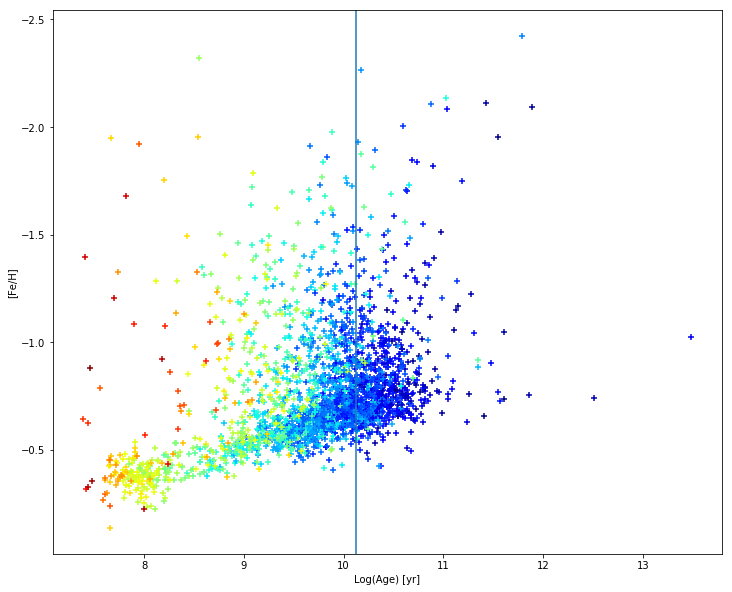

In [8]:
#Age Metallicity Plot
plt.figure(figsize=[12,10])
plt.scatter(b_age,clndr16['FE_H'],marker='+',c=clndr16['LOGG'],cmap='jet')
plt.axvline(x=np.log10(ageU))
plt.gca().invert_yaxis()
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'[Fe/H]')
plt.show()

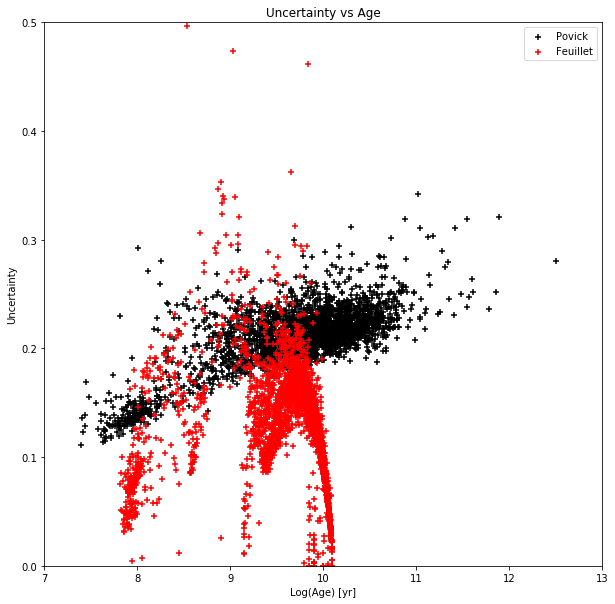

In [9]:
#Age Uncertainty Plot
plt.figure(figsize=[10,10])
plt.scatter(b_age,devs,c='k',marker='+',label='Povick')
plt.scatter(pdfout['P_MEAN'],pdfout['P_VAR'],c='r',marker='+',label='Feuillet')
plt.xlim(7,13)
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty')
plt.ylim(0.0,0.5)
plt.title(r'Uncertainty vs Age')
plt.legend()
plt.savefig('uncert_age.pdf',bbox_inches='tight')
plt.show()

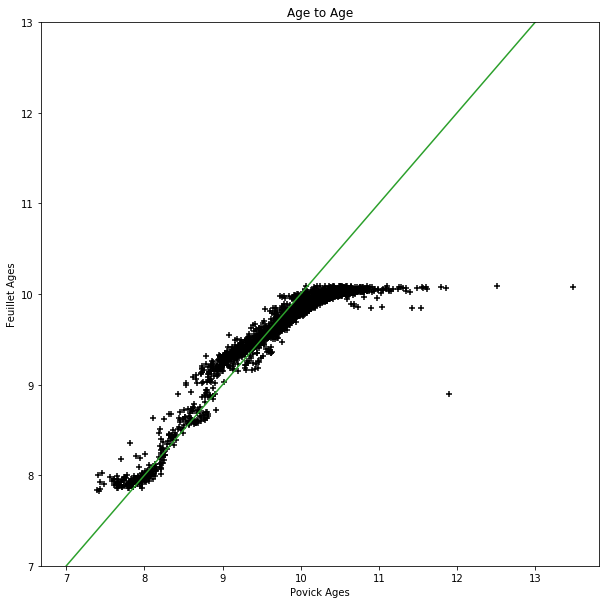

In [10]:
#Age-2-Age Plot
plt.figure(figsize=[10,10])
plt.scatter(b_age,pdfout['P_MEAN'][clnr],c='k',marker='+')
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
plt.ylim(7,13)
plt.xlabel(r'Povick Ages')
plt.ylabel(r'Feuillet Ages')
plt.title(r'Age to Age')
plt.savefig('age_age.pdf',bbox_inches='tight')
plt.show()